## EDA

In [113]:
#importo librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from itertools import combinations

In [114]:
import os

# Cargo el archivo CSV
df = pd.read_csv("bookings.csv")

In [115]:
# ANÁLISIS BÁSICO DEL DATASET 
print("=" * 60)
print("ANÁLISIS BÁSICO DEL DATASET")
print("=" * 60)

# Información general
print(f"\n📊 INFORMACIÓN GENERAL:")
print(f"Shape: {df.shape}")
print(f"Columnas ({df.shape[1]}): {df.columns.tolist()}")

# Tipos de datos
print(f"\n🔍 TIPOS DE DATOS:")
dtype_counts = df.dtypes.value_counts()
print(f"Distribución tipos: {dtype_counts.to_dict()}")

# Valores nulos
print(f"\n❌ VALORES NULOS:")
total_nulos = df.isnull().sum().sum()
print(f"Nulos totales: {total_nulos}")

# Duplicados
print(f"\n🔄 DUPLICADOS:")
total_duplicados = df.duplicated().sum()
print(f"Duplicados totales: {total_duplicados}")

# Valores únicos
print(f"\n🔢 VALORES ÚNICOS:")
for col in df.columns:
    unicos = df[col].nunique()
    print(f"  {col}: {unicos} únicos ({unicos/len(df)*100:.1f}%)") 

ANÁLISIS BÁSICO DEL DATASET

📊 INFORMACIÓN GENERAL:
Shape: (239400, 13)
Columnas (13): ['Booking', 'Request date', 'Requested by', 'Authorized by', 'Department', 'Currency', 'Amount', 'Reason', 'Reason 2', 'Status', 'CustomerShortname', 'CustomerRegion', 'Amount COMGES in EUR']

🔍 TIPOS DE DATOS:
Distribución tipos: {dtype('O'): 13}

❌ VALORES NULOS:
Nulos totales: 97

🔄 DUPLICADOS:
Duplicados totales: 2

🔢 VALORES ÚNICOS:
  Booking: 239393 únicos (100.0%)
  Request date: 156 únicos (0.1%)
  Requested by: 134 únicos (0.1%)
  Authorized by: 43 únicos (0.0%)
  Department: 1 únicos (0.0%)
  Currency: 26 únicos (0.0%)
  Amount: 9796 únicos (4.1%)
  Reason: 7 únicos (0.0%)
  Reason 2: 39 únicos (0.0%)
  Status: 5 únicos (0.0%)
  CustomerShortname: 687 únicos (0.3%)
  CustomerRegion: 5 únicos (0.0%)
  Amount COMGES in EUR: 9301 únicos (3.9%)


In [116]:
# Porcentaje de nulos por columna
porcentaje_nulos = (df.isnull().mean() * 100).round(2)
print(porcentaje_nulos) 

Booking                 0.00
Request date            0.00
Requested by            0.00
Authorized by           0.00
Department              0.00
Currency                0.00
Amount                  0.00
Reason                  0.00
Reason 2                0.04
Status                  0.00
CustomerShortname       0.00
CustomerRegion          0.00
Amount COMGES in EUR    0.00
dtype: float64


In [117]:
#usamos un booleano: False si es nulo
print(df.notnull())

        Booking  Request date  Requested by  Authorized by  Department  \
0          True          True          True           True        True   
1          True          True          True           True        True   
2          True          True          True           True        True   
3          True          True          True           True        True   
4          True          True          True           True        True   
...         ...           ...           ...            ...         ...   
239395     True          True          True          False        True   
239396     True          True          True           True        True   
239397     True          True          True           True        True   
239398     True          True          True           True        True   
239399     True          True          True           True        True   

        Currency  Amount  Reason  Reason 2  Status  CustomerShortname  \
0           True    True    True      

In [118]:
# 🔍 VERIFICAR REQUISITOS ESPECÍFICOS
print("🔍 VERIFICACIÓN DE REQUISITOS")
print("=" * 60)

# 1. ❌ Verificar duplicados por reserva + cantidad
print("\n1️⃣ DUPLICADOS POR RESERVA + CANTIDAD:")
if 'Booking' in df.columns and 'Amount' in df.columns:
    duplicates_booking = df.groupby(['Booking', 'Amount']).size()
    duplicates_over_2 = duplicates_booking[duplicates_booking > 2]
    print(f"   Reservas con >2 peticiones misma cantidad: {len(duplicates_over_2)}")
    if len(duplicates_over_2) > 0:
        print("   ⚠️ PROBLEMA: Hay reservas con más de 2 peticiones")
        print(duplicates_over_2.head())
    else:
        print("   ✅ OK: No hay reservas con >2 peticiones misma cantidad")

# 2. ❌ Verificar Authorized by
print("\n2️⃣ AUTHORIZED BY:")
auth_cols = [col for col in df.columns if 'authorized' in col.lower() or 'author' in col.lower()]
if auth_cols:
    auth_col = auth_cols[0]
    nulos_auth = df[auth_col].isnull().sum()
    print(f"   Columna encontrada: '{auth_col}'")
    print(f"   Peticiones sin autorización: {nulos_auth}")
    if nulos_auth > 0:
        print("   ❌ PROBLEMA: Hay peticiones sin autorización")
        
        # ELIMINAR FILAS CON NULOS EN AUTHORIZED BY
        filas_antes = len(df)
        df = df.dropna(subset=[auth_col])
        filas_despues = len(df)
        eliminadas = filas_antes - filas_despues
        print(f"   ✅ Eliminadas {eliminadas} filas sin autorización")
        print(f"   ✅ Dataset: {filas_antes} → {filas_despues} filas")
    else:
        print("   ✅ OK: Todas las peticiones tienen autorización")

# 3. ❌ Verificar formato emails
print("\n3️⃣ FORMATO DE EMAILS:")
# Buscar columnas que contengan 'email', 'mail', 'requested by' o 'authorized by'
email_cols = []
for col in df.columns:
    col_lower = col.lower()
    if ('email' in col_lower or 'mail' in col_lower or 
        'requested by' in col_lower or 'authorized by' in col_lower):
        email_cols.append(col)
if email_cols:
    import re
    email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    for col in email_cols:
        emails = df[col].dropna()
        invalid_emails = emails[~emails.str.match(email_pattern, na=False)]
        print(f"   Columna '{col}': {len(invalid_emails)} emails inválidos")
        if len(invalid_emails) > 0:
            print("   ❌ PROBLEMA: Hay emails con formato incorrecto")
            print(f"   Ejemplos: {list(invalid_emails.head(3))}")
            
            # CORREGIR EMAILS AUTOMÁTICAMENTE
            def fix_email(email):
                if pd.isna(email):
                    return email
                if 'hotelbeds.com' in email and '@' not in email:
                    return email.replace('hotelbeds.com', '@hotelbeds.com')
                return email
            
            df[col] = df[col].apply(fix_email)
            
            # Verificar corrección
            invalid_after = df[col][~df[col].str.match(email_pattern, na=False)]
            print(f"   ✅ Emails corregidos. Inválidos restantes: {len(invalid_after)}")
        else:
            print("   ✅ OK: Todos los emails tienen formato correcto")
else:
    print("   ⚠️ No se encontraron columnas de email")

# 4. ❌ Convertir todo a EUR y eliminar columna
print("\n4️⃣ CONVERSIÓN A EUROS:")

# Convertir columnas a numéricas
df['Amount'] = pd.to_numeric(df['Amount'].str.replace(',', '.'), errors='coerce')
df['Amount COMGES in EUR'] = pd.to_numeric(df['Amount COMGES in EUR'].str.replace(',', '.'), errors='coerce')

# Verificar los tipos
print(f"   Amount: {df['Amount'].dtype}")
print(f"   Amount COMGES in EUR: {df['Amount COMGES in EUR'].dtype}")

# IMPUTACIÓN PARA COLUMNAS NUMÉRICAS:
print(f"   Nulos en 'Amount' ANTES de imputar: {df['Amount'].isnull().sum()}")
print(f"   Nulos en 'Amount COMGES in EUR' ANTES de imputar: {df['Amount COMGES in EUR'].isnull().sum()}")

# Imputar valores nulos numéricos con la mediana porque es mejor para datos financieros
if df['Amount'].isnull().sum() > 0:
    df['Amount'] = df['Amount'].fillna(df['Amount'].median())
if df['Amount COMGES in EUR'].isnull().sum() > 0:
    df['Amount COMGES in EUR'] = df['Amount COMGES in EUR'].fillna(df['Amount COMGES in EUR'].median())

print(f"   Nulos en 'Amount' DESPUÉS de imputar: {df['Amount'].isnull().sum()}")
print(f"   Nulos en 'Amount COMGES in EUR' DESPUÉS de imputar: {df['Amount COMGES in EUR'].isnull().sum()}")

if 'Amount COMGES in EUR' in df.columns:
    # Usar la columna EUR como referencia y eliminar la otra
    df['Amount_EUR'] = df['Amount COMGES in EUR'].copy()
    df = df.drop('Amount COMGES in EUR', axis=1)
    print("   ✅ Creada columna Amount_EUR")
    print("   ✅ Eliminada columna 'Amount COMGES in EUR'")
    
    # Verificar el resultado
    print(f"   Nueva columna Amount_EUR creada con tipo: {df['Amount_EUR'].dtype}")
else:
    print("   ⚠️ Columna 'Amount COMGES in EUR' no encontrada")

# 5. ❌ Verificar columna Reason
print("\n5️⃣ COLUMNA REASON:")
if 'Reason' in df.columns:
    nulos_reason = df['Reason'].isnull().sum()
    print(f"   Nulos en 'Reason': {nulos_reason}")
    if nulos_reason > 0:
        print("   ❌ PROBLEMA: Reason es obligatoria pero tiene nulos")
        
        # ELIMINAR FILAS CON NULOS EN REASON
        filas_antes = len(df)
        df = df.dropna(subset=['Reason'])
        filas_despues = len(df)
        eliminadas = filas_antes - filas_despues
        print(f"   ✅ Eliminadas {eliminadas} filas sin Reason")
        print(f"   ✅ Dataset: {filas_antes} → {filas_despues} filas")
    else:
        print("   ✅ OK: Todas las peticiones tienen Reason")

if 'Reason 2' in df.columns:
    nulos_reason2 = df['Reason 2'].isnull().sum()
    print(f"   Nulos en 'Reason 2': {nulos_reason2} (recomendada)")
    print("   ℹ️ Reason 2 es recomendada, no obligatoria - se mantienen los nulos")

🔍 VERIFICACIÓN DE REQUISITOS

1️⃣ DUPLICADOS POR RESERVA + CANTIDAD:
   Reservas con >2 peticiones misma cantidad: 1
   ⚠️ PROBLEMA: Hay reservas con más de 2 peticiones
Booking      Amount
100/1239393  144,54    3
dtype: int64

2️⃣ AUTHORIZED BY:
   Columna encontrada: 'Authorized by'
   Peticiones sin autorización: 2
   ❌ PROBLEMA: Hay peticiones sin autorización
   ✅ Eliminadas 2 filas sin autorización
   ✅ Dataset: 239400 → 239398 filas

3️⃣ FORMATO DE EMAILS:
   Columna 'Requested by': 3 emails inválidos
   ❌ PROBLEMA: Hay emails con formato incorrecto
   Ejemplos: ['user69hotelbeds.com', 'user38hotelbeds.com', 'user101hotelbeds.com']
   ✅ Emails corregidos. Inválidos restantes: 0
   Columna 'Authorized by': 0 emails inválidos
   ✅ OK: Todos los emails tienen formato correcto

4️⃣ CONVERSIÓN A EUROS:
   Amount: float64
   Amount COMGES in EUR: float64
   Nulos en 'Amount' ANTES de imputar: 55
   Nulos en 'Amount COMGES in EUR' ANTES de imputar: 8
   Nulos en 'Amount' DESPUÉS de im

## Visualización

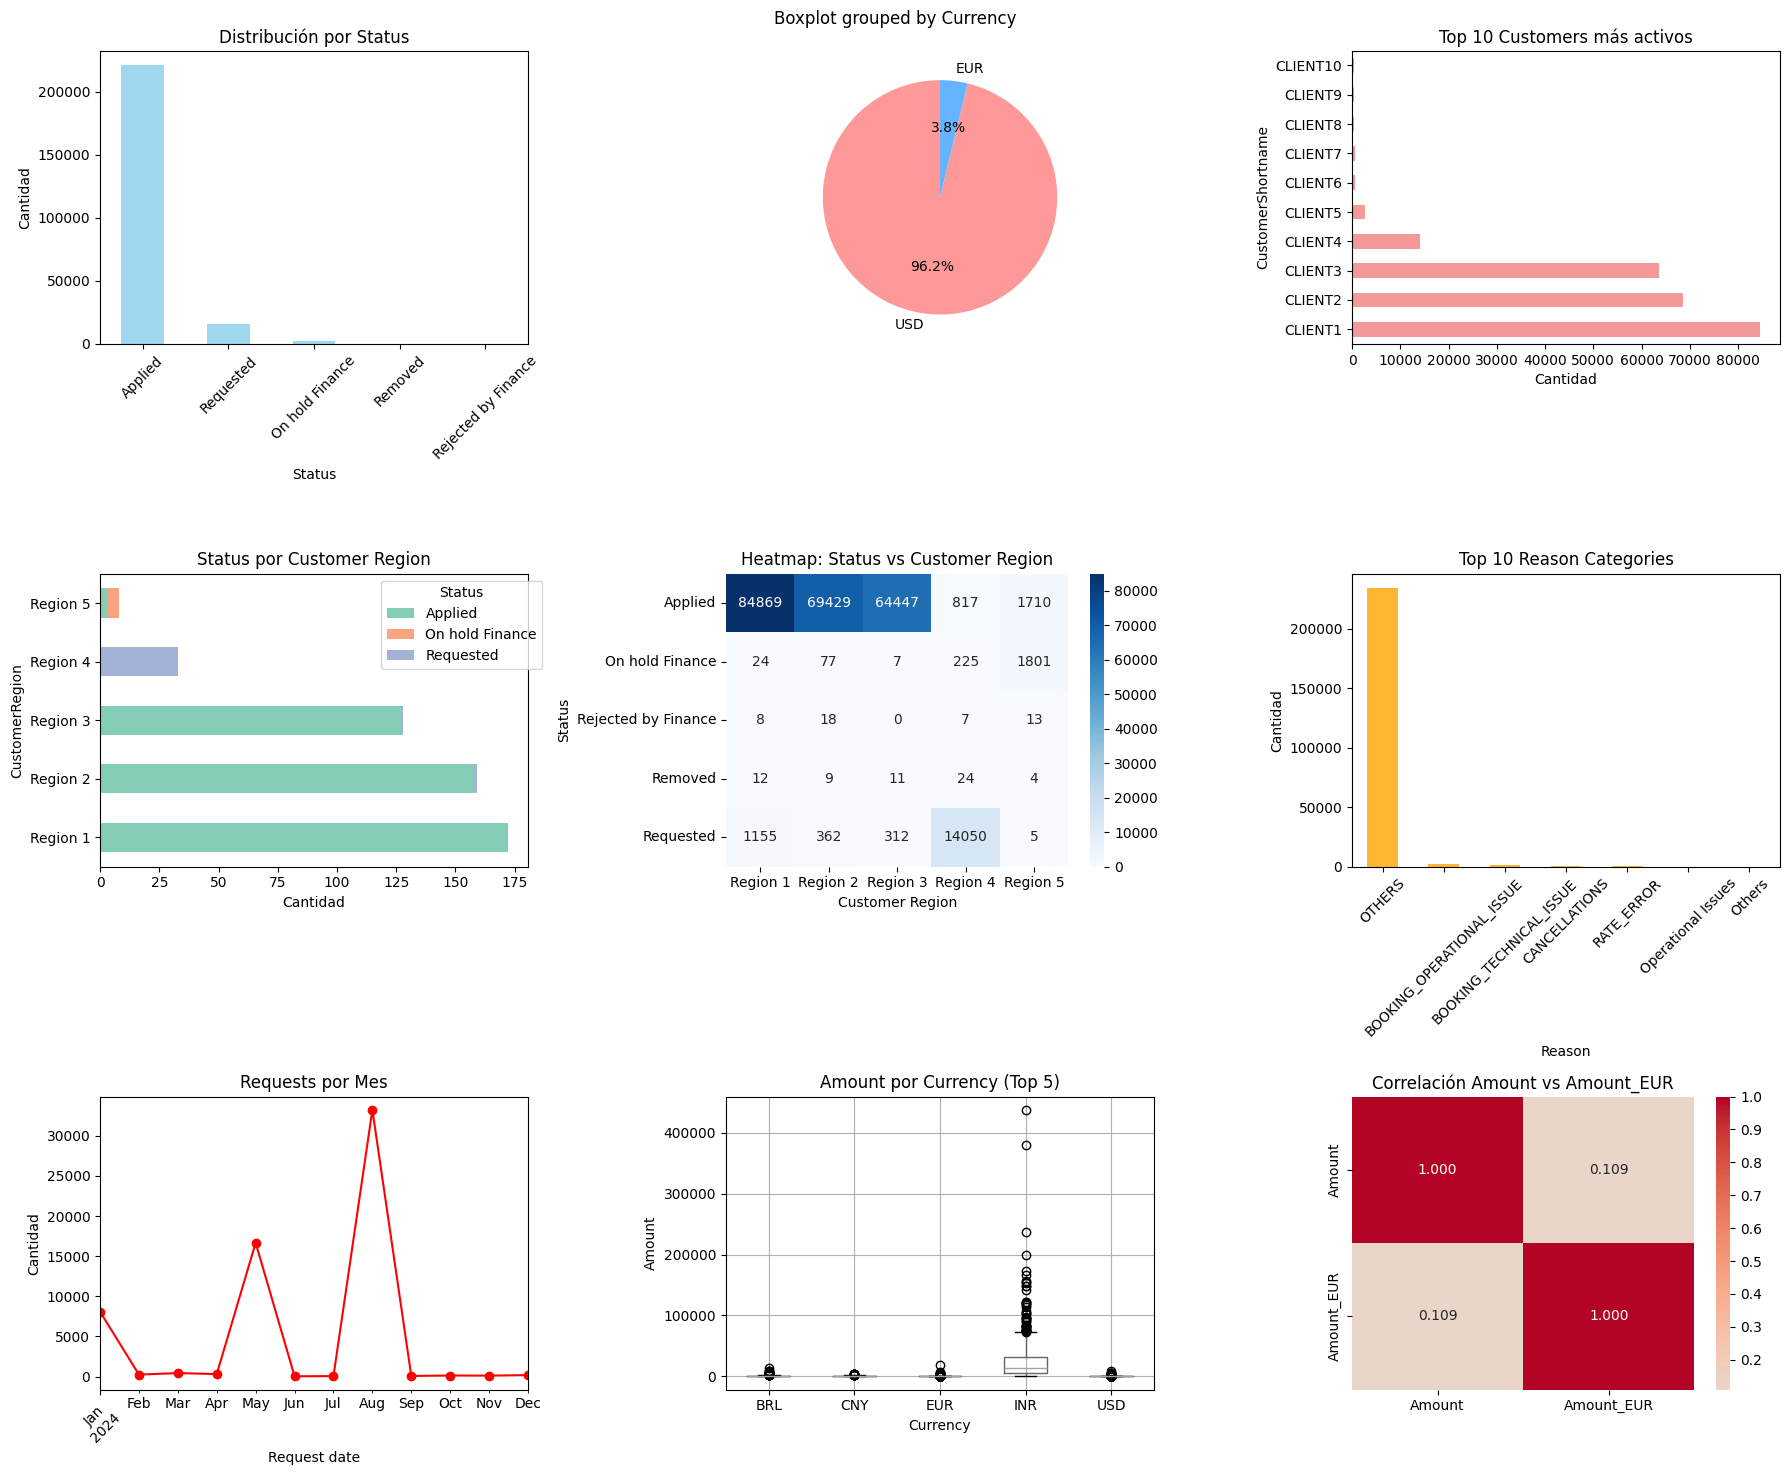

In [119]:
# Configurar estilo
plt.style.use('default')
sns.set_palette("Set2")

# Crear figura con múltiples subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Análisis Exploratorio - Dataset Bookings', fontsize=16, fontweight='bold')

# 1. Distribución por Status
ax1 = axes[0, 0]
status_counts = df['Status'].value_counts()
status_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Distribución por Status')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)

# 2. Currency Distribution 
ax2 = axes[0, 1]
currency_counts = df['Currency'].value_counts().head(2)
colors = ['#ff9999','#66b3ff','#99ff99']
currency_counts.plot(kind='pie', ax=ax2, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_ylabel('')

# 3. Top 10 Customers más activos
ax3 = axes[0, 2]  # ← Cambiar a posición disponible
customer_counts = df['CustomerShortname'].value_counts().head(10)
customer_counts.plot(kind='barh', ax=ax3, color='lightcoral', alpha=0.8)
ax3.set_title('Top 10 Customers más activos')
ax3.set_xlabel('Cantidad')

# 4. Count plot Status vs Region (HORIZONTAL)
ax4 = axes[1, 0]
df_sample = df.sample(n=min(500, len(df)))  # Muestra para evitar saturación
status_region = df_sample.groupby(['CustomerRegion', 'Status']).size().unstack(fill_value=0)
status_region.plot(kind='barh', ax=ax4, alpha=0.8, stacked=True)
ax4.set_title('Status por Customer Region')
ax4.set_xlabel('Cantidad')
ax4.legend(title='Status', bbox_to_anchor=(1.05, 1))

# 5. Heatmap horizontal Status vs Region
ax5 = axes[1, 1]
# Crear tabla de contingencia
heatmap_data = df.groupby(['Status', 'CustomerRegion']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, cmap='Blues', ax=ax5, fmt='d', cbar=True)
ax5.set_title('Heatmap: Status vs Customer Region')
ax5.set_xlabel('Customer Region')
ax5.set_ylabel('Status')

# 6. Top 10 Reason Categories
ax6 = axes[1, 2]
reason_counts = df['Reason'].value_counts().head(10)
reason_counts.plot(kind='bar', ax=ax6, color='orange', alpha=0.8)
ax6.set_title('Top 10 Reason Categories')
ax6.set_ylabel('Cantidad')
ax6.tick_params(axis='x', rotation=45)

# 7. Evolución temporal de requests (si es posible)
ax7 = axes[2, 0]
try:
    df_temp = df.copy()
    df_temp['Request date'] = pd.to_datetime(df_temp['Request date'], errors='coerce')
    monthly_requests = df_temp['Request date'].dt.to_period('M').value_counts().sort_index()
    if len(monthly_requests) > 1:
        monthly_requests.plot(kind='line', marker='o', ax=ax7, color='red')
        ax7.set_title('Requests por Mes')
        ax7.set_ylabel('Cantidad')
        ax7.tick_params(axis='x', rotation=45)
    else:
        ax7.text(0.5, 0.5, 'Datos insuficientes\npara serie temporal', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Evolución Temporal')
except:
    ax7.text(0.5, 0.5, 'Error procesando\nfechas', 
            ha='center', va='center', transform=ax7.transAxes)
    ax7.set_title('Evolución Temporal')

# 8. Boxplot Amount por Currency (top 5)
ax8 = axes[2, 1]
top_currencies = df['Currency'].value_counts().head(5).index
df_top_curr = df[df['Currency'].isin(top_currencies)]
df_top_curr.boxplot(column='Amount', by='Currency', ax=ax8)
ax8.set_title('Amount por Currency (Top 5)')
ax8.set_xlabel('Currency')
ax8.set_ylabel('Amount')

# 9. Heatmap de correlación entre variables numéricas
ax9 = axes[2, 2]
# CAMBIAR ESTA LÍNEA:
if 'Amount_EUR' in df.columns:
    numeric_data = df[['Amount', 'Amount_EUR']].corr()
    sns.heatmap(numeric_data, annot=True, cmap='coolwarm', center=0, ax=ax9, fmt='.3f')
    ax9.set_title('Correlación Amount vs Amount_EUR')
else:
    # Si no existe Amount_EUR, mostrar solo Amount
    ax9.text(0.5, 0.5, 'Solo columna Amount\ndisponible', 
            ha='center', va='center', transform=ax9.transAxes)
    ax9.set_title('Variables Numéricas')

plt.tight_layout()
plt.show()